In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.append('./llm-transparency-tool')

from llm_transparency_tool.models.tlens_model import TransformerLensTransparentLlm
from llm_transparency_tool.models.transparent_llm import ModelInfo
from llm_transparency_tool.routes.graph import GraphBuilder, build_full_graph, build_paths_to_predictions

from src.utils import obtain_all_ice_variants, evaluate, load_model_and_tokenizer
from src.information_flow_routes import generate_graphs, take_operators_operands_nodes_from_contribution_graphs, plot_information_flow_graphs

import networkx as nx
import random
import torch
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "facebook/opt-6.7b"
DATASET_PATH = './data/opt_6_7b_data.pt'
TAU_THRESHOLD = 0.035

This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64



### Load the model and the dataset

In [4]:
tokenizer, model = load_model_and_tokenizer(MODEL_NAME, device)
model_information_flow = TransformerLensTransparentLlm(
    model_name=MODEL_NAME,
    device='gpu'
)
dataset = torch.load(DATASET_PATH)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model facebook/opt-6.7b into HookedTransformer


### Preprocess the dataset

In [5]:
dataset_no_ice, dataset_single_ice, _, _ = obtain_all_ice_variants(dataset)

### Evaluate the model on the dataset

In [6]:
results_no_ice, results_single_ice = [evaluate(tokenizer, model, data, batch_size=10, prepend_bos=True) for data in [dataset_no_ice, dataset_single_ice]]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [7]:
results = [results_no_ice, results_single_ice]
print("Results (No ICE, Single ICE):", [np.round(np.mean(res), 3) for res in results])

Results (No ICE, Single ICE): [0.205, 0.319]


### Obtain information flow graphs

In [8]:
information_flow_graphs = generate_graphs(model_information_flow, dataset_single_ice, results_single_ice, threshold=TAU_THRESHOLD)

  0%|          | 0/210 [00:00<?, ?it/s]

2025-11-04 07:44:09.715 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 07:44:09.813 
  command:

    streamlit run /home/eickhoff/esx208/.conda/envs/icl_mech_interp/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-11-04 07:44:09.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 07:44:09.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-11-04 07:44:10.328 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 07:44:10.329 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 07:44:23.808 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 07:44:23.809 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loaded pretrained model facebook/opt-6.7b into HookedTransformer


### Obtain from all graphs nodes related to operands, operators, and the result token

In [9]:
information_flow_graphs_main_nodes = take_operators_operands_nodes_from_contribution_graphs(information_flow_graphs, tokenizer)

### Plot information flow graphs

/home/eickhoff/esx208/.conda/envs/icl_mech_interp/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


  0%|          | 0/67 [00:00<?, ?it/s]

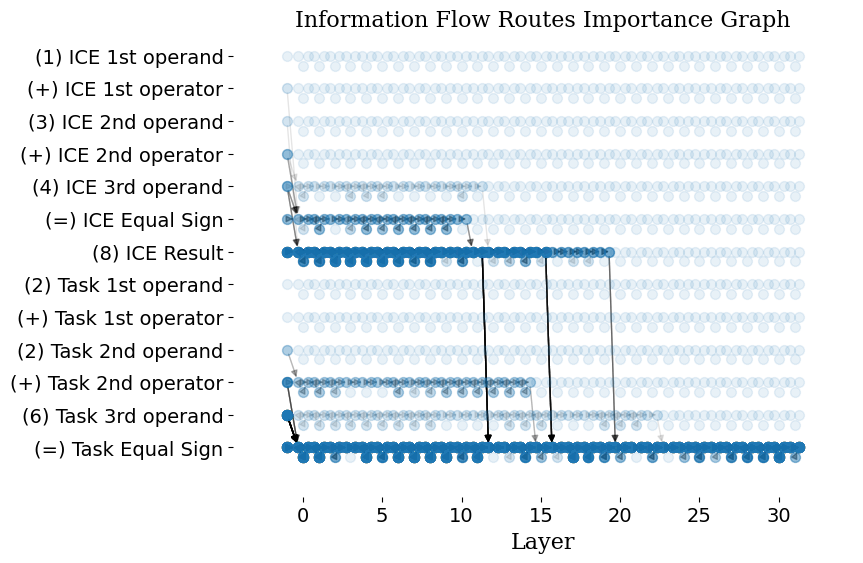

In [10]:
plot_information_flow_graphs(information_flow_graphs_main_nodes, save_path=None)

### Obtain information flow graphs for all importance thresholds (TBD)